# Kernel Methods for understanding data

**Author: Miguel Zabaleta Sarasa (100463947)**

In [1]:
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics import pairwise_distances
import scipy
import matplotlib.pyplot as plt

def plot_gallery(images, titles, h, w, n_row=4, n_col=10):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(images.shape[0]):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        #plt.colorbar()
        if titles is not None:
            plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

In [2]:
"""
Teacher's implementation of Kernel Fisher Discriminant with an RBF kernel.
"""

from sklearn.base import BaseEstimator, ClassifierMixin
class RBFKernelFisherDiscriminant(BaseEstimator, ClassifierMixin):
  def __init__(self, gamma=1, alpha=1e-4):
    # gamma: parameter for the RBF kernel
    # alpha: parameter for making the eigenvalue problem stable. You don't need to touch it
    self.gamma = gamma
    self.alpha = alpha
  def get_params(self, deep=True):
    # suppose this estimator has parameters "alpha" and "recursive"
    return {"alpha": self.alpha, "gamma": self.gamma}
 
  def set_params(self, **parameters):
    for parameter, value in parameters.items():
        setattr(self, parameter, value)
    return self
    
  def fit(self, X, Y):
    """
    X: matrix with observations, each row is an observation
    Y: targets
    """
    
    self._X = X.copy()
    self._n = X.shape[0]
    # compute kernel
    K0 = rbf_kernel(X, gamma=self.gamma)
    # center kernel
    sumK = np.sum(K0,0)
    K1 = 1./self._n*np.tile(np.reshape(sumK,(-1,1)), (1,self._n))
    K2 = 1./self._n * np.tile(np.reshape(sumK,(1,-1)), (self._n,1))
    self._K = K0.copy()
    K = K0 -  K1 - K2 + np.mean(K0)

    n = K.shape[0]
    self.v_classes = np.unique(Y)
    M_ = np.mean(K,1)
    P = len(self.v_classes)
    M_Mp = np.empty((n,P))
    #Sb
    Sb = np.zeros((self._n,self._n))
    Sw = np.zeros((self._n,self._n))
    for p in range(P):
        idx_class_p = np.where(Y == self.v_classes[p])[0]
        n_p = len(idx_class_p)
        Kp = K[:,idx_class_p]
        Mp = np.mean(Kp,1)
        M_Mp[:,p] = Mp.copy()
        MpM_ = Mp - M_
        Sb += n_p* np.outer(MpM_, MpM_.T) # column * row
        Sw += 1./n_p* Kp.dot(Kp.T) - np.outer(Mp, Mp.T)
    #Sw inv
    Sw = 0.5*(Sw+Sw.T) + 1e-6*np.eye(Sw.shape[0])
    Sb = 0.5*(Sb+Sb.T) + 1e-6*np.eye(Sb.shape[0])
    
    DD2, UU2 = scipy.linalg.eigh(Sb, Sw)
    lam = DD2[-P+1:]
    self.A = UU2[:,-P+1:]
    self.VMp = M_Mp.T.dot(self.A)
    return self
    
  def fit_transform(self, X, Y):
    """
    X: matrix with observations, each row is an observation
    Y: targets
    """
    self._X = X.copy()
    self._n = X.shape[0]
    # compute kernel
    K0 = rbf_kernel(X, gamma=self.gamma)
    # center kernel
    sumK = np.sum(K0,0)
    K1 = 1./self._n*np.tile(np.reshape(sumK,(-1,1)), (1,self._n))
    K2 = 1./self._n * np.tile(np.reshape(sumK,(1,-1)), (self._n,1))
    self._K = K0.copy()
    K = K0 -  K1 - K2 + np.mean(K0)

    n = K.shape[0]
    self.v_classes = np.unique(Y)
    M_ = np.mean(K,1)
    P = len(self.v_classes)
    M_Mp = np.empty((n,P))
    #Sb
    Sb = np.zeros((self._n,self._n))
    Sw = np.zeros((self._n,self._n))
    for p in range(P):
        idx_class_p = np.where(Y == self.v_classes[p])[0]
        n_p = len(idx_class_p)
        Kp = K[:,idx_class_p]
        Mp = np.mean(Kp,1)
        M_Mp[:,p] = Mp.copy()
        MpM_ = Mp - M_
        Sb += n_p* np.outer(MpM_, MpM_.T) # column * row
        Sw += 1./n_p* Kp.dot(Kp.T) - np.outer(Mp, Mp.T)
    #Sw inv
    Sw = 0.5*(Sw+Sw.T) + 1e-6*np.eye(Sw.shape[0])
    Sb = 0.5*(Sb+Sb.T) + 1e-6*np.eye(Sb.shape[0])
    
    DD2, UU2 = scipy.linalg.eigh(Sb, Sw)
    lam = DD2[-P+1:]
    self.A = UU2[:,-P+1:]
    self.VMp = M_Mp.T.dot(self.A)
    return K.dot(self.A)

  def transform(self, X):
    nt = X.shape[0]
    K0 = rbf_kernel(X, self._X, gamma=self.gamma)
    K1 = (K0 - 1./self._n * np.ones((nt, self._n)).dot(self._K))
    K2 = np.eye(self._n)- 1./self._n * np.ones((self._n, self._n))
    K = K1.dot(K2)
    return K.dot(self.A)

  def predict(self, X):
    U = self.transform(X)
    Distance_sample_mean = pairwise_distances(U, self.VMp)
    closest_mean = np.argmin(Distance_sample_mean,1)
    output = np.array([self.v_classes[ii] for ii in closest_mean])
    return output

  def score(self, X, Y):
    labels = self.predict(X)
    return np.mean(labels==Y)

# Introduction

In this assignment we will work in a face recognition task using multivariate analysis methods. The dataset (Olivetti Faces) consists of ten different images taken from 40 distinct subjects. For some subjects, the images were taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). 

The next code includes the lines to download this data set and create the training and test data partitions.


The first time that you download the data it can take a while...
Dataset size information:
n_features: 4096
n_classes: 40
Size of the training set 280
Size of the test set 120


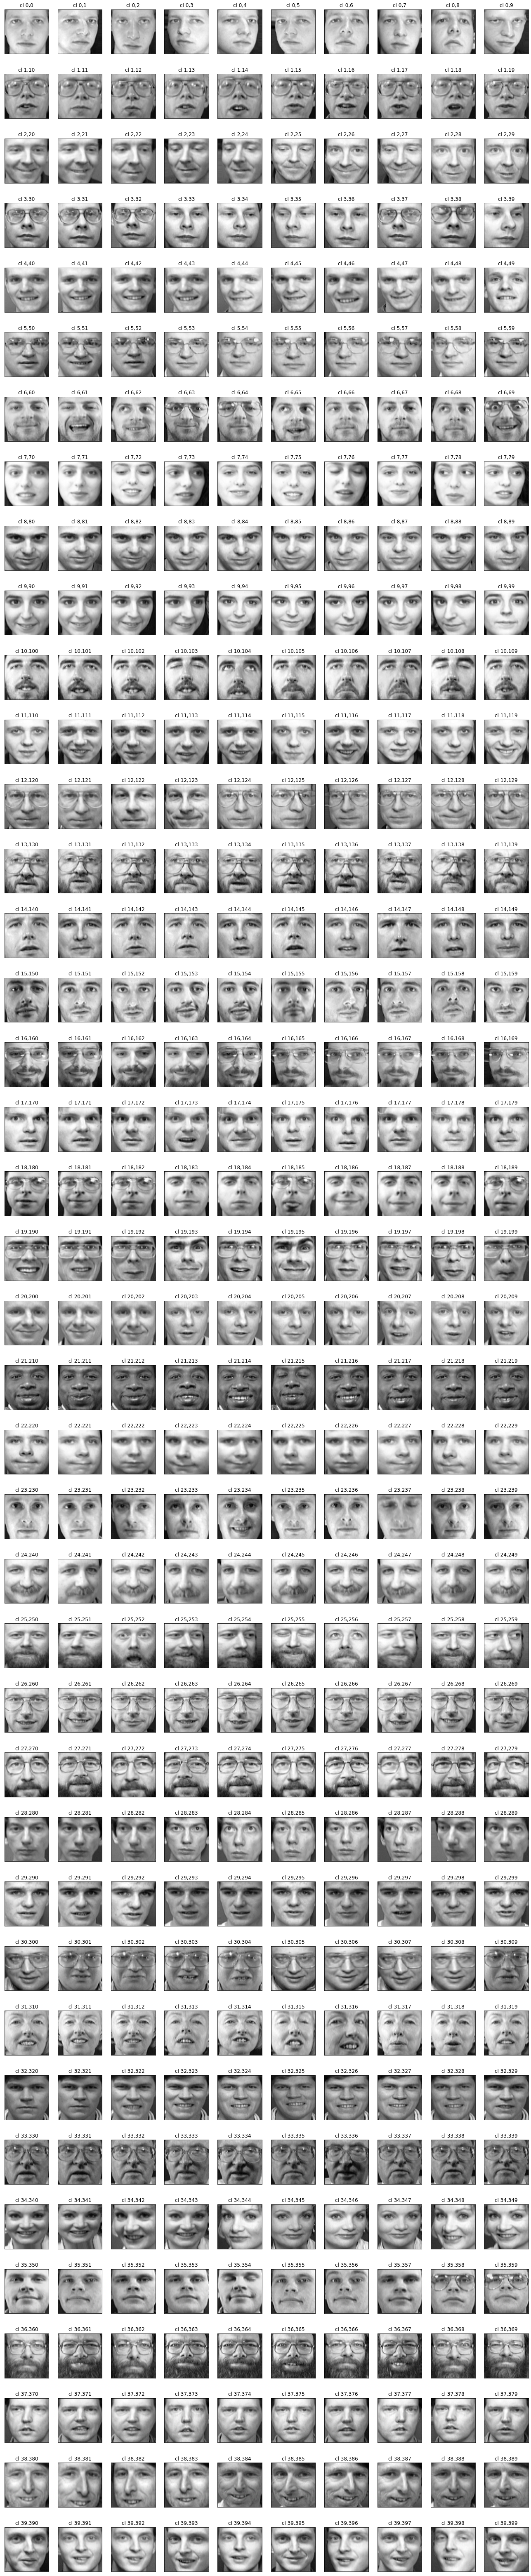

In [3]:
from sklearn.datasets import fetch_olivetti_faces 

print('The first time that you download the data it can take a while...')
olivetti_people = fetch_olivetti_faces()

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = olivetti_people.images.shape

X = olivetti_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
Y = olivetti_people.target
class_names = np.unique(Y)
n_classes = class_names.shape[0]

print("Dataset size information:")
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

# As example, we plot a face of each class (or person)
titles = ['cl '+str(c)+","+str(ic) for ic,c in enumerate(Y)]
ind_faces = [np.where(Y == c)[0][0] for c in class_names]

plot_gallery(X[:,:], titles, h, w, n_row=40)

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=41)

print("Size of the training set {0:d}".format(X_train.shape[0]))
print("Size of the test set {0:d}".format(X_test.shape[0]))

We will evaluate the performance of 5 different schemes for classification (the face recognition task is a classification task where each subject forms an output class):

- SVM acting on the original image data
- PCA + SVM: First perform a dimensionality reduction with PCA and then train a SVM on the transformed data
- LDA: A Fisher Classifier (Linear Discriminant Analysis) acting on the original image data  
- Kernel PCA + linear SVM. Perform a non-linear dimensionality reduction with a Kernel PCA (using an RBF kernel) and then train a linear SVM with the transformed data
- Kernel Discriminant Analysis acting on the original data

# 1. Train the detectors

The first task is to learn the corresponding model with every scheme. Each scheme needs to fix some hyperparameters. We will use **cross-validation** to find values for these hyperparameters and then fit the models.

For the cross validation, we will **select carefully the number of folds**. Notice that the number of instances of each class in the training set is not large, at least you need one instance of each class in each fold...

In [4]:
# Observations are ordered per class:
# for Y_train, 0-6 belong to class 0, 7-13 to class 1, ..., and so on
# Need to check that there is at least one observation of each class on every fold
# There are 40 classes

from sklearn.model_selection import KFold

# Let's do a preliminary analysis,
# trying 5 and 6 folds for 50.000 different random_state values
for rs in range(50000):
    for n_folds in [5,6]:
        find = False
        kf = KFold(n_splits=n_folds,shuffle=True,random_state=rs)
        for train, val in kf.split(Y_train):
            for j in range(40):
                class_index = list(range(7*j,7*(j+1)))
                
                # if no elements in class_index are in at least one train or validation fold, break loop
                if (len([i for i in class_index if i in train]) == 0) or (len([i for i in class_index if i in val]) == 0):
                    # fold is not valid
                    find = True
                    break
                    
                # if we get to the last fold and to this point, the splitting is successful
                if j==39:
                    print('\n','random_state',rs)
                    print('n_folds',n_folds)
                    print('successful fold')
            if find:
                break

# This doesn't return anything, so 5 folds is not a good choice

In [5]:
# Let's try with 3 and 4 folds instead (100 random_state values)
for rs in range(100):
    for n_folds in [3,4]:
        find = False
        kf = KFold(n_splits=n_folds,shuffle=True,random_state=rs)
        for train, val in kf.split(Y_train):
            for j in range(40):
                class_index = list(range(7*j,7*(j+1)))
                
                # if no elements in class_index are in at least one train or validation fold, break loop
                if (len([i for i in class_index if i in train]) == 0) or (len([i for i in class_index if i in val]) == 0):
                    # fold is not valid
                    find = True
                    break
                    
                # if we get to the last fold and to this point, the splitting is successful
                if j==39:
                    print('\n','random_state',rs)
                    print('n_folds',n_folds)
                    print('successful fold')
            if find:
                break

# Finally, we decide to implement 3 folds, with random_state=99
cross_validation = KFold(n_splits=3, shuffle=True, random_state=99)


 random_state 0
n_folds 3
successful fold

 random_state 7
n_folds 3
successful fold

 random_state 14
n_folds 3
successful fold

 random_state 22
n_folds 3
successful fold

 random_state 25
n_folds 3
successful fold

 random_state 52
n_folds 3
successful fold

 random_state 99
n_folds 3
successful fold


In [6]:
# 1. SVM
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# ranges for gamma and C
v_gamma = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
v_C = [0.001, .01, .1, 1, 10, 100, 1000]

# grid of parameters
param_grid = [
    {'C': v_C, 'gamma': v_gamma, 'kernel': ['rbf']},
    {'C': v_C, 'kernel': ['linear']},
]

# define and fit the model
model1 = GridSearchCV(
        SVC(random_state=100463947),
        param_grid,
        cv = cross_validation
        )
model1.fit(X_train, Y_train)

GridSearchCV(cv=KFold(n_splits=3, random_state=99, shuffle=True),
             estimator=SVC(random_state=100463947),
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'gamma': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'kernel': ['rbf']},
                         {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'kernel': ['linear']}])

In [7]:
# 2. PCA + SVM
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipe = Pipeline([("scaler", StandardScaler()), 
                 ("pca", PCA(random_state=100463947)), 
                 ('svc', SVC(random_state=100463947))])
param_grid = [
    {'pca__n_components':list(range(2,110,5)),'svc__C': v_C, 'svc__gamma': v_gamma, 'svc__kernel': ['rbf']},
    {'pca__n_components':list(range(2,110,5)),'svc__C': v_C, 'svc__kernel': ['linear']},
]

# define and fit the model
model2 = GridSearchCV(
        pipe,
        param_grid,
        cv = cross_validation
        )
model2.fit(X_train, Y_train)

GridSearchCV(cv=KFold(n_splits=3, random_state=99, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(random_state=100463947)),
                                       ('svc', SVC(random_state=100463947))]),
             param_grid=[{'pca__n_components': [2, 7, 12, 17, 22, 27, 32, 37,
                                                42, 47, 52, 57, 62, 67, 72, 77,
                                                82, 87, 92, 97, 102, 107],
                          'svc__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'svc__gamma': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'svc__kernel': ['rbf']},
                         {'pca__n_components': [2, 7, 12, 17, 22, 27, 32, 37,
                                                42, 47, 52, 57, 62, 67, 72, 77,
                                                82, 87, 92, 97, 102, 107],
                          'svc__C': [0.0

In [8]:
# 3. LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

model3 = LinearDiscriminantAnalysis()
model3.fit(X_train, Y_train)

LinearDiscriminantAnalysis()

In [9]:
# 4. KPCA + SVM
from sklearn.decomposition import KernelPCA
pipe = Pipeline([("scaler", StandardScaler()), 
                 ("kpca", KernelPCA(random_state=100463947)), 
                 ('svc', SVC(random_state=100463947))])
kpca_dict1 = {'kpca__n_components':list(range(2,110,5)), 'kpca__gamma': v_gamma, 'kpca__kernel': ['rbf']}
kpca_dict2 =  {'kpca__n_components':list(range(2,110,5)), 'kpca__kernel': ['linear']}
param_grid = [
    {**kpca_dict1, 'svc__C': v_C, 'svc__gamma': v_gamma, 'svc__kernel': ['rbf']},
    {**kpca_dict2, 'svc__C': v_C, 'svc__gamma': v_gamma, 'svc__kernel': ['rbf']},
    {**kpca_dict1, 'svc__C': v_C, 'svc__kernel': ['linear']},
    {**kpca_dict2, 'svc__C': v_C, 'svc__kernel': ['linear']}
]

# define and fit the model
model4 = GridSearchCV(
        pipe,
        param_grid,
        cv = cross_validation
        )
model4.fit(X_train, Y_train)

C:\Users\mzaba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
2296 fits failed out of a total of 29568.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2296 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\mzaba\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\mzaba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\mzaba\anaconda3\lib\site-packages\sklearn\pipeline.py", line 348, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\mzaba\

GridSearchCV(cv=KFold(n_splits=3, random_state=99, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('kpca',
                                        KernelPCA(random_state=100463947)),
                                       ('svc', SVC(random_state=100463947))]),
             param_grid=[{'kpca__gamma': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'kpca__kernel': ['rbf'],
                          'kpca__n_components': [2, 7, 12, 17, 22, 27, 32, 37,
                                                 42, 47, 52, 57, 62, 67, 72, 77,
                                                 82,...
                          'kpca__kernel': ['rbf'],
                          'kpca__n_components': [2, 7, 12, 17, 22, 27, 32, 37,
                                                 42, 47, 52, 57, 62, 67, 72, 77,
                                                 82, 87, 92, 97, 102, 107],
                          'sv

In [10]:
# 5. KDA

# grid of parameters
param_grid = [
    {'gamma': v_gamma},
]

# define and fit the model
model5 = GridSearchCV(
        RBFKernelFisherDiscriminant(),
        param_grid,
        cv = cross_validation
        )
model5.fit(X_train, Y_train)

GridSearchCV(cv=KFold(n_splits=3, random_state=99, shuffle=True),
             estimator=RBFKernelFisherDiscriminant(),
             param_grid=[{'gamma': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}])

# 2. Evaluation of the methods in the test set

Next we will construct a data frame called `results_df` that has as index an array with these names to identidy the 5 methods:
1. 'SVM'
2. 'PCA + SVM'
3. 'LDA'
4. 'KPCA + SVM'
5. 'KDA'

The values of the data frame are the **classification accuracy on the test set** achieved by the corresponding method

In [11]:
from sklearn.metrics import accuracy_score
import pandas as pd

acc1 = model1.score(X_test,Y_test)

scaler2 = model2.best_estimator_.named_steps['scaler']
pca2 = model2.best_estimator_.named_steps['pca']
svc2 = model2.best_estimator_.named_steps['svc']

X_transf = pca2.transform(scaler2.transform(X_test))
Y_pred = svc2.predict(X_transf)

acc2 = accuracy_score(Y_test,Y_pred)

acc3 = model3.score(X_test,Y_test)

scaler4 = model4.best_estimator_.named_steps['scaler']
pca4 = model4.best_estimator_.named_steps['kpca']
svc4 = model4.best_estimator_.named_steps['svc']

X_transf = pca4.transform(scaler4.transform(X_test))
Y_pred = svc4.predict(X_transf)

acc4 = accuracy_score(Y_test,Y_pred)

mod5 = model5.best_estimator_
acc5 = accuracy_score(Y_test,mod5.predict(X_test))

results_df = pd.DataFrame({'acc_score': [acc1,acc2,acc3,acc4,acc5]},
                          index=['SVM','PCA + SVM','LDA','KPCA + SVM','KDA'])

print(results_df)

            acc_score
SVM          0.941667
PCA + SVM    0.933333
LDA          0.966667
KPCA + SVM   0.933333
KDA          0.950000


#### Discussion

We can see that the model that performs the **best** is the **LDA**, which wrongly classifies 4% of the images.  
The **worst** performing models are the **PCA + SVM** and the **KPCA + SVM**, both with an error of 6.6%.  

Comparing these models to the one without dimensionality reduction (SVM), this one has an accuracy of 94.1%.  
Comparing the percentage increase in error between these models, we have that the PCA + SVM and KPCA + SVM have **13.55% more error** than the SVM model ( (1-0.933)/(1-0.941) - 1 = 0.1355 )

The next best performing model is the KDA (error of 5%, second best model).

We can also remark that performing a **PCA or a KPCA** before the SVM seems to **worsen** the model.  
This seems reasonable, as performing a dimensionality reduction translates into having less information to fit the target variable.  
For PCA, the feature space is always of smaller dimension than the original input space.  
For KPCA, this can not be the case. In our particular implementation, we only considered a maximum number of components of 100, so the feature space will also necessarily be smaller in size.

# 3. Impact of the number of components in the reduced dimension space 

In [12]:
dim1 = X.shape[1]

dim2 = model2.best_params_['pca__n_components']

dim3 = 39 
# for LDA, since we the dimension reduction is done internally, the default value is min(n_classes-1, n_features) = 39

dim4 = model4.best_params_['kpca__n_components']


# The classification on KDA takes place by comparing the minimum distance of u with the projections for each class
# So, we need to know the dimension of u, wich is equal to the number of columns of A (rows of A.t)
# We know that the columns of A are the eigenvectors of the largest L−1 eigenvalues of Sw-1*Sb
# Therefore, the number of columns of Sw-1*Sb will be the dimension of the feature space
# The transform method returns K*A, so looking at the columns of that output should give us the right answer

dim5 = model5.transform(X_train).shape[1]

results_df['red_dim'] = [dim1,dim2,dim3,dim4,dim5]

{'pca__n_components': 72, 'svc__C': 0.001, 'svc__kernel': 'linear'}


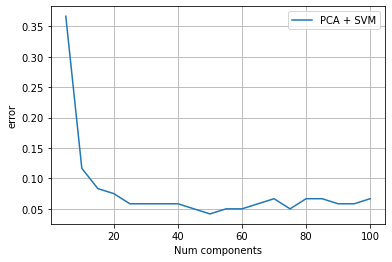

In [13]:
# PCA + SVM error evolution plot
print(model2.best_params_) # C=1, kernel=linear

# define and fit the model
errors = list()
for comp in range(5,105,5):
    pipe = Pipeline([("scaler", StandardScaler()), 
                   ("pca", PCA(n_components=comp, random_state=100463947)), 
                 ('svc', SVC(C=1,
                             kernel='linear',
                             random_state=100463947))])
    pipe.fit(X_train, Y_train)

    scaler2 = pipe.named_steps['scaler']
    pca2 = pipe.named_steps['pca']
    svc2 = pipe.named_steps['svc']

    X_transf = pca2.transform(scaler2.transform(X_test))
    Y_pred = svc2.predict(X_transf)

    acc2 = accuracy_score(Y_test,Y_pred)
    error = 1-acc2
    errors.append(error)


plt.figure()

plt.plot(list(range(5,105,5)), errors, label='PCA + SVM')

plt.legend()
plt.xlabel('Num components')
plt.ylabel('error')
plt.grid()

{'kpca__kernel': 'linear', 'kpca__n_components': 72, 'svc__C': 0.001, 'svc__kernel': 'linear'}


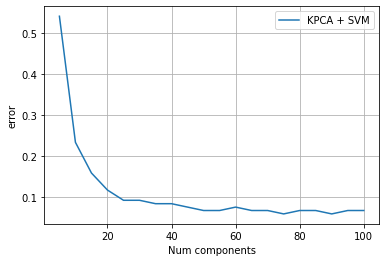

In [14]:
# PCA + SVM error evolution plot
print(model4.best_params_) # C=0.001, kernel=linear

# define and fit the model
errors = list()
for comp in range(5,105,5):
    pipe = Pipeline([("scaler", StandardScaler()), 
                   ("kpca", KernelPCA(n_components=comp,
                                      kernel='linear',
                                     random_state=100463947)), 
                 ('svc', SVC(C=0.001,
                             kernel='linear',
                             random_state=100463947))])
    pipe.fit(X_train, Y_train)

    scaler4 = pipe.named_steps['scaler']
    pca4 = pipe.named_steps['kpca']
    svc4 = pipe.named_steps['svc']

    X_transf = pca4.transform(scaler4.transform(X_test))
    Y_pred = svc4.predict(X_transf)

    acc4 = accuracy_score(Y_test,Y_pred)
    error = 1-acc4
    errors.append(error)


plt.figure()

plt.plot(list(range(5,105,5)), errors, label='KPCA + SVM')

plt.legend()
plt.xlabel('Num components')
plt.ylabel('error')
plt.grid()

#### Discussion

Considering a reasonable accurate classifier one that achieves an accuracy >0.9, on the PCA + SVM model, we achieve an error of 0.1 with around **12 components.**     
As for the KPCA + SVM, this threshold is obtained a bit later, as we need to use around **23 components**.

Therefore, those should be the minimum number of components to be used, as the error tends to decrease as the number of componentes increases.

# 4. Performance with the test set contaminated with noise

Now we are studying the robustness of the 5 detectors to cope with test images contaminated with noise. The contamination consists in to add zero mean gaussian noise to each pixel of the image.

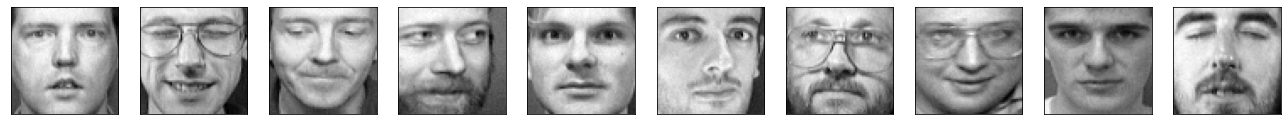

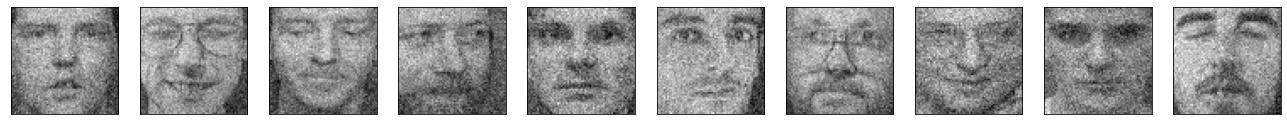

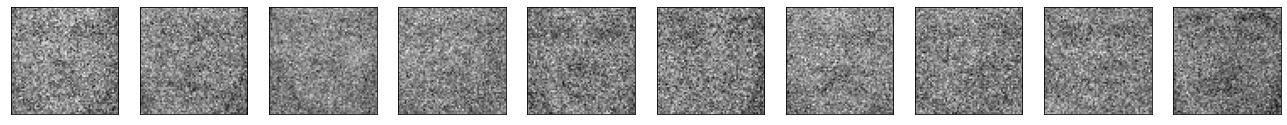

In [15]:
for s_noise in [.01, .1, .5]:
    noisy_test = X_test + s_noise * np.random.randn(X_test.shape[0], X_test.shape[1])
    plot_gallery(noisy_test[:10,:], None, h, w, n_row=1)

For **noise variances** of $[10^{-4}, 0.0004, 0.0025, 0.01, 0.04, 0.25, 1, 4]$ we will evaluate the accuracy of the already trained detectors using a contaminated test set.

In [16]:
for s_noise in [1e-4,0.0004,0.0025,0.01,0.04,0.25,1,4]:
    noisy_test = X_test + s_noise * np.random.randn(X_test.shape[0], X_test.shape[1])
    
    acc1 = model1.score(noisy_test,Y_test)

    scaler2 = model2.best_estimator_.named_steps['scaler']
    pca2 = model2.best_estimator_.named_steps['pca']
    svc2 = model2.best_estimator_.named_steps['svc']

    X_transf = pca2.transform(scaler2.transform(noisy_test))
    Y_pred = svc2.predict(X_transf)

    acc2 = accuracy_score(Y_test,Y_pred)

    acc3 = model3.score(noisy_test,Y_test)

    scaler4 = model4.best_estimator_.named_steps['scaler']
    pca4 = model4.best_estimator_.named_steps['kpca']
    svc4 = model4.best_estimator_.named_steps['svc']

    X_transf = pca4.transform(scaler4.transform(noisy_test))
    Y_pred = svc4.predict(X_transf)

    acc4 = accuracy_score(Y_test,Y_pred)

    mod5 = model5.best_estimator_
    acc5 = accuracy_score(Y_test,mod5.predict(noisy_test))

    results_df['s_noise '+str(s_noise)] = [acc1,acc2,acc3,acc4,acc5]

In [17]:
results_df.round(3)

acc_score  red_dim  s_noise 0.0001  s_noise 0.0004  \
SVM             0.942     4096           0.942           0.942   
PCA + SVM       0.933       72           0.933           0.933   
LDA             0.967       39           0.967           0.967   
KPCA + SVM      0.933       72           0.933           0.933   
KDA             0.950       39           0.950           0.950   

            s_noise 0.0025  s_noise 0.01  s_noise 0.04  s_noise 0.25  \
SVM                  0.942         0.942         0.942         0.942   
PCA + SVM            0.933         0.942         0.925         0.933   
LDA                  0.967         0.967         0.950         0.892   
KPCA + SVM           0.933         0.942         0.925         0.933   
KDA                  0.950         0.950         0.950         0.800   

            s_noise 1  s_noise 4  
SVM             0.817      0.292  
PCA + SVM       0.817      0.275  
LDA             0.358      0.083  
KPCA + SVM      0.817      0.267  
KDA             0.017      0.017

#### Discussion

1. The **SVM** is quite robust, as it mantains its accuracy score until the noise variance is equal to 1, where the accuracy drops to 0.817.  
Finally, it achieves a 0.292 accuracy with noise variance equal to 4.


2. The **PCA + SVM** is less robust than the SVM, as the performance is first negatively affected by the noise level when it is equal to 0.04. However, we see it presents an interesting behavior. The accuracy is at its highest (0.942) when the noise variance is equal to 0.01.  
After that, the accuracy drops again to 0.925, and then it goes back to the original score (0.933 with noise level equal to 0.25).  
Finally, the largest noise factor affects the accuracy in a larger manner than the SVM, as it dops to 0.275.


3. The **LDA** model also starts noticing the effects of the noise level at s_noise = 0.04.  
It then consistently drops in accuracy reaching 0.083 (much lower than the others).


4. The **KPCA + SVM** presents a similar behavior to the PCA + SVM, having the first drop in accuracy when noise variance is equal to 0.04, but with an increase in accuracy when the noise variance is 0.01.  
The biggest noise factor seems to affect the performance in a similar way to the PCA + SVM, reaching an accuracy of 0.267


5. The **KDA** model begins to drop its accuracy when noise variance is equal to 0.25, and it keeps droping across the rest of the variances.  
In particular, having a noise variance of 1 results in a performance of 0.017, which is the worst performance out of all the models.  
Therefore, we can say that this is the model which noise variance affects the most when the noise level is reasonably high.

In **summary**, all models are reasonably robust to low levels of noise variance, and some of them even manage to **improve** their **performance** (**PCA + SVM** and **KPCA + SVM**).  

We know that at least for PCA, the last components tend to only explain noise.  
Hence, by adding more noise to the images, we could be helping the model to extract all the noise into single components (which wont be used for predicting).  
Therefore, performing the PCA/KPCA could help removing the noise present in the variables, and somehow result in utilizing the most important information in the feature space, hence achieving an improve in performance.

Finally, we can highlight that the models which seems **most affected** by the noise level are the **LDA and KPA**, as they respectively have an accuracy of **0.358 and 0.017** when the noise variance is equal to 1, while the rest of the models all have an accuracy **above 0.8** at that level. 

# 5. Extra (I)

Now, we will use the KDA and LDA to transform the data and then learn a SVM with the transformed data and discuss how does this affect the performance.

In [18]:
# KDA + SVM
X_transf = model5.transform(X_train)
model1.fit(X_transf,Y_train)

X_test_transf = model5.transform(X_test)
Y_pred = model1.predict(X_test_transf)

accuracy_score(Y_test,Y_pred)

0.95

In [19]:
# LDA + SVM
X_transf = model3.transform(X_train)
model1.fit(X_transf,Y_train)

X_test_transf = model3.transform(X_test)
Y_pred = model1.predict(X_test_transf)

accuracy_score(Y_test,Y_pred)

0.975

These are our final results:

- **SVM**: 0.942

- **PCA + SVM**: 0.933

- **KPCA + SVM**: 0.933

- **KDA + SVM**: 0.95

- **LDA + SVM**: 0.975

As we can see, the two last transformations have **improved the performance**, both comparing them between the other SVM model with transformations, and also compared to the SVM model alone.  

Remarkably, we have obtained our best overall model among these transformations, with **LDA + SVM** achieving an accuracy of **0.975** (**KDA + SVM** performed as good as the KDA model, with 0.95 accuracy).

